Total ratings: 2365
Total unique users: 74
Training set: 1949 ratings
Test set: 416 ratings
First 5 rows of the dataset:
+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    1|  36| 239|   3.0|
|    2|  72|  26|   1.0|
|    3|  59| 430|   2.5|
|    4|  72| 284|   3.0|
+-----+----+----+------+
only showing top 5 rows

Evaluating model with N = 2...
N = 2, RMSE = 1.1559602036286756
Evaluating model with N = 3...
N = 3, RMSE = 1.0758427659275236
Evaluating model with N = 4...
N = 4, RMSE = 1.047045623488704
Evaluating model with N = 5...
N = 5, RMSE = 1.0529592708143511
Evaluating model with N = 6...
N = 6, RMSE = 1.0431509173266924
Evaluating model with N = 7...
N = 7, RMSE = 1.029347165027473
Evaluating model with N = 8...
N = 8, RMSE = 1.0185260771404259
Evaluating model with N = 9...
N = 9, RMSE = 1.016346683481586
Evaluating model with N = 10...
N = 10, RMSE = 1.0115341953042292
Evaluating model with N = 11...
N = 11, RMSE = 1.02015

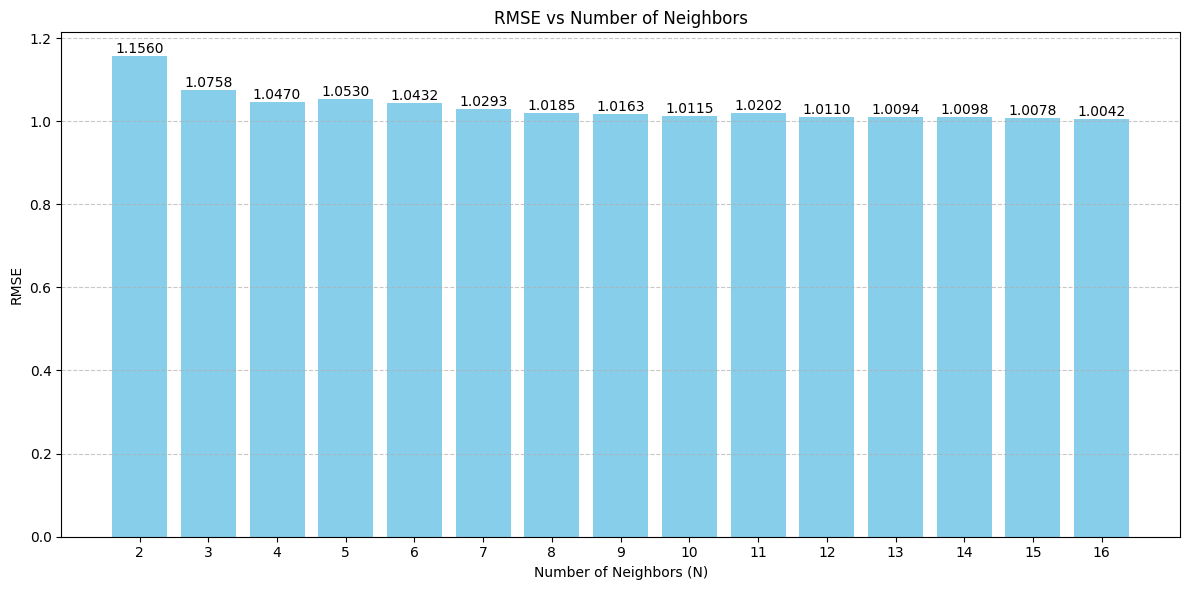

Best N: 16 with RMSE: 1.004234394525966
Top 5 recommendations for user 68:
+----+------------------+
|item|  predicted_rating|
+----+------------------+
| 241|               5.0|
|  97|               5.0|
| 377|4.9283232507919985|
| 386|4.9090782763779215|
|  25|4.8250922946103305|
+----+------------------+



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, collect_list, struct, lit, avg, count, sqrt, sum as spark_sum,
    abs as spark_abs, broadcast, when, row_number, pow as F_pow, greatest, least
)
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, DoubleType
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import SparseVector, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

class CollaborativeFilteringLSH:
    def __init__(self, n_neighbors, ratings_df):
        self.n_neighbors = n_neighbors
        self.ratings_df = ratings_df
        self.spark = ratings_df.sparkSession

        # Fill missing ratings with 0
        self.ratings_df = self.ratings_df.na.fill(0.0, subset=["rating"])

        # Calculate average ratings for each user
        self.user_mean_ratings = self.ratings_df.groupBy("user").agg(
            avg("rating").alias("mean_rating")
        )

        # Compute rating deviation (rating - mean_rating)
        self.ratings_with_mean = self.ratings_df.join(self.user_mean_ratings, on="user")
        self.ratings_with_mean = self.ratings_with_mean.withColumn(
            "rating_deviation", col("rating") - col("mean_rating")
        )

        # Create user profiles for reference
        self.user_profiles = self.ratings_with_mean.select(
            "user", "item", "rating", "mean_rating", "rating_deviation"
        ).groupBy("user").agg(
            collect_list(struct("item", "rating", "rating_deviation")).alias("profile")
        )

        # Create binary sparse vectors for LSH
        user_item_sets = self.ratings_df.select("user", "item").groupBy("user").agg(
            collect_list("item").alias("items")
        )

        def create_sparse_vector(items):
            item_indices = sorted(set(items))
            return SparseVector(10000, item_indices, [1.0] * len(item_indices))

        vector_udf = udf(create_sparse_vector, VectorUDT())
        self.user_item_vectors = user_item_sets.withColumn("features", vector_udf("items"))

        # LSH
        mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
        self.lsh_model = mh.fit(self.user_item_vectors)

    def find_similar_users(self, target_user_id):
        target_vector_df = self.user_item_vectors.filter(col("user") == target_user_id)
        if target_vector_df.count() == 0:
            return self.spark.createDataFrame([], schema=StructType([
                StructField("user", IntegerType(), True),
                StructField("pearson_similarity", DoubleType(), True)
            ]))

        target_vector_df = target_vector_df.select("features").limit(1)
        lsh_neighbors = self.lsh_model.approxNearestNeighbors(
            dataset=self.user_item_vectors,
            key=target_vector_df.first()["features"],
            numNearestNeighbors=self.n_neighbors * 3
        )
        candidate_users_df = lsh_neighbors.filter(col("user") != target_user_id).select("user")

        target_ratings = self.ratings_with_mean.filter(col("user") == target_user_id) \
            .selectExpr("item as item_t", "rating_deviation as dev_t")
        candidate_ratings = self.ratings_with_mean.join(broadcast(candidate_users_df), on="user") \
            .repartition("item")
        target_ratings = target_ratings.repartition("item")

        joined = candidate_ratings.join(broadcast(target_ratings), candidate_ratings.item == target_ratings.item_t)
        common_items = joined.groupBy("user").agg(count("item").alias("common_count"))
        joined = joined.join(common_items, on="user").filter(col("common_count") >= 2)

        joined = joined.withColumn("numerator", col("rating_deviation") * col("dev_t")) \
                      .withColumn("sq1", col("rating_deviation")**2) \
                      .withColumn("sq2", col("dev_t")**2)

        sim_df = joined.groupBy("user").agg(
            spark_sum("numerator").alias("numerator"),
            sqrt(spark_sum("sq1")).alias("denom1"),
            sqrt(spark_sum("sq2")).alias("denom2"),
            count("item").alias("common_items")
        ).withColumn("pearson_similarity",
            col("numerator") / (col("denom1") * col("denom2"))
        )

        sim_df = sim_df.filter((col("pearson_similarity").isNotNull()) &
                              (col("pearson_similarity") != 0) &
                              (col("denom1") > 0) &
                              (col("denom2") > 0))

        top_similar = sim_df.orderBy(col("pearson_similarity").desc()).limit(self.n_neighbors)
        return top_similar

    def find_similar_users_batch(self, target_user_ids_df, n_neighbors=None):
        if n_neighbors is None:
            n_neighbors = self.n_neighbors

        target_vectors_df = target_user_ids_df.join(self.user_item_vectors, on="user", how="inner").select("user", "features")

        # Use LSH for approximate similarity join
        lsh_neighbors = self.lsh_model.approxSimilarityJoin(
            datasetA=target_vectors_df,
            datasetB=self.user_item_vectors,
            threshold=0.9,
            distCol="jaccardDist"
        ).filter(col("datasetA.user") != col("datasetB.user")) \
         .select(col("datasetA.user").alias("target_user"), col("datasetB.user").alias("candidate_user")) \
         .distinct()

        target_ratings = self.ratings_with_mean.select("user", "item", "rating_deviation").alias("target")
        candidate_ratings = self.ratings_with_mean.select("user", "item", "rating_deviation").alias("candidate")

        joined = lsh_neighbors.join(target_ratings, lsh_neighbors.target_user == col("target.user")) \
            .join(candidate_ratings, (lsh_neighbors.candidate_user == col("candidate.user")) & (col("target.item") == col("candidate.item")))

        sim_df = joined.groupBy("target_user", "candidate_user").agg(
            spark_sum(col("target.rating_deviation") * col("candidate.rating_deviation")).alias("numerator"),
            spark_sum(col("target.rating_deviation")**2).alias("sum_sq_target"),
            spark_sum(col("candidate.rating_deviation")**2).alias("sum_sq_candidate"),
            count("target.item").alias("common_items")
        )

        sim_df = sim_df.filter(col("common_items") >= 2)
        sim_df = sim_df.withColumn("pearson_similarity",
            when((col("sum_sq_target") > 0) & (col("sum_sq_candidate") > 0),
                 col("numerator") / (sqrt(col("sum_sq_target")) * sqrt(col("sum_sq_candidate")))).otherwise(None)
        ).filter(col("pearson_similarity").isNotNull() & (col("pearson_similarity") != 0))

        window = Window.partitionBy("target_user").orderBy(col("pearson_similarity").desc())
        top_similar_df = sim_df.withColumn("rank", row_number().over(window)).filter(col("rank") <= n_neighbors)
        result_df = top_similar_df.select(col("target_user").alias("userA"), col("candidate_user").alias("userB"), col("pearson_similarity"))
        return result_df

    def predict(self, target_user_id, top_n=10):
        target_user_rated_items_df = self.ratings_df.filter(
            (col("user") == target_user_id) & (col("rating") > 0)
        ).select("item")

        # Find similar users
        similar_users_df = self.find_similar_users(target_user_id)
        if similar_users_df.count() == 0:
            return self.spark.createDataFrame([], schema=StructType([
                StructField("item", IntegerType(), True),
                StructField("predicted_rating", FloatType(), True)
            ]))

        target_user_mean_row = self.user_mean_ratings.filter(col("user") == target_user_id)
        target_user_mean = target_user_mean_row.select("mean_rating").first()["mean_rating"]
        sim_ratings = self.ratings_with_mean.join(similar_users_df, on="user")

        # Filter out items already rated by target user
        sim_ratings = sim_ratings.join(target_user_rated_items_df, on="item", how="left_anti")

        predictions = sim_ratings.withColumn(
            "weighted_rating", col("pearson_similarity") * col("rating_deviation")
        ).withColumn(
            "abs_similarity", spark_abs(col("pearson_similarity"))
        ).groupBy("item").agg(
            spark_sum("weighted_rating").alias("weighted_sum"),
            spark_sum("abs_similarity").alias("sim_sum")
        ).withColumn(
            "predicted_rating",
            lit(target_user_mean) + (col("weighted_sum") / col("sim_sum"))
        ).filter(col("sim_sum") > 0)

        # Ensure ratings are within valid range (0-5)
        predictions = predictions.withColumn(
            "predicted_rating",
            greatest(lit(0.0), least(lit(5.0), col("predicted_rating")))
        )

        result = predictions.select("item", "predicted_rating").orderBy(
            col("predicted_rating").desc()
        ).limit(top_n)

        return result

def evaluate_model(n_neighbors, train_df, test_df):
    cf = CollaborativeFilteringLSH(n_neighbors=n_neighbors, ratings_df=train_df)

    test_users_df = test_df.select("user").distinct()

    similar_users_df = cf.find_similar_users_batch(test_users_df, n_neighbors)

    user_mean_df = cf.user_mean_ratings
    ratings_with_mean_df = cf.ratings_with_mean

    test_with_mean = test_df.join(user_mean_df, on="user", how="left")
    test_with_mean = test_with_mean.na.fill({"mean_rating": 0.0})

    # Join test data with similar users
    test_with_similar = test_with_mean.join(
        similar_users_df,
        test_with_mean.user == similar_users_df.userA,
        "left"
    ).select(
        test_with_mean.user,
        test_with_mean.item,
        test_with_mean.rating,
        test_with_mean.mean_rating,
        similar_users_df.userB,
        similar_users_df.pearson_similarity
    )

    # Get ratings from similar users
    sim_ratings = test_with_similar.join(
        ratings_with_mean_df,
        (test_with_similar.userB == ratings_with_mean_df.user) &
        (test_with_similar.item == ratings_with_mean_df.item),
        "inner"
    )

    # Calculate weighted ratings
    predictions = sim_ratings.withColumn(
        "weighted_rating", col("pearson_similarity") * col("rating_deviation")
    ).withColumn(
        "abs_similarity", spark_abs(col("pearson_similarity"))
    ).groupBy(
        test_with_similar.user, test_with_similar.item,
        test_with_similar.rating, test_with_similar.mean_rating
    ).agg(
        spark_sum("weighted_rating").alias("weighted_sum"),
        spark_sum("abs_similarity").alias("sim_sum")
    )

    # Calculate predicted ratings
    predictions = predictions.withColumn(
        "predicted_rating",
        when(col("sim_sum") > 0,
             col("mean_rating") + (col("weighted_sum") / col("sim_sum"))
        ).otherwise(col("mean_rating"))
    )

    # Ensure ratings are within valid range (0-5)
    predictions = predictions.withColumn(
        "predicted_rating",
        greatest(lit(0.0), least(lit(5.0), col("predicted_rating")))
    )

    result = predictions.select(
        "user", "item", "rating", "predicted_rating"
    )

    if result.count() == 0:
        return float('inf')

    # Use RegressionEvaluator for RMSE calculation
    evaluator = RegressionEvaluator(
        labelCol="rating",
        predictionCol="predicted_rating",
        metricName="rmse"
    )

    rmse = evaluator.evaluate(result)
    return rmse if rmse is not None else float('inf')

def main():
    spark = SparkSession.builder \
        .appName("Collaborative Filtering with LSH") \
        .getOrCreate()

    file_path = "ratings2k.csv"
    schema = StructType([
        StructField("index", IntegerType(), True),
        StructField("user", IntegerType(), True),
        StructField("item", IntegerType(), True),
        StructField("rating", FloatType(), True)
    ])
    ratings_df = spark.read.csv(file_path, header=True, schema=schema)

    # Ensure ratings are filled properly (0 for missing)
    ratings_df = ratings_df.na.fill(0.0, subset=["rating"])

    train_df, test_df = ratings_df.randomSplit([0.8, 0.2], seed=42)

    total_users = ratings_df.select("user").distinct().count()

    print(f"Total ratings: {ratings_df.count()}")
    print(f"Total unique users: {total_users}")
    print(f"Training set: {train_df.count()} ratings")
    print(f"Test set: {test_df.count()} ratings")
    print("First 5 rows of the dataset:")
    ratings_df.show(5)

    n_values = list(range(2, 17))
    rmse_values = []

    for n in n_values:
        print(f"Evaluating model with N = {n}...")
        rmse = evaluate_model(n, train_df, test_df)
        rmse_values.append(rmse)
        print(f"N = {n}, RMSE = {rmse}")

    results_df = pd.DataFrame({
        'N': n_values,
        'RMSE': rmse_values
    })

    plt.figure(figsize=(12, 6))
    bars = plt.bar(results_df['N'], results_df['RMSE'], color='skyblue')
    plt.xlabel('Number of Neighbors (N)')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Number of Neighbors')
    plt.xticks(n_values)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.4f}',
            ha='center',
            va='bottom'
        )

    plt.tight_layout()
    plt.show()

    best_n = n_values[np.argmin(rmse_values)]
    print(f"Best N: {best_n} with RMSE: {min(rmse_values)}")

    best_model = CollaborativeFilteringLSH(n_neighbors=best_n, ratings_df=ratings_df)

    example_user = 68
    recommendations = best_model.predict(example_user, top_n=5)
    print(f"Top 5 recommendations for user {example_user}:")
    recommendations.show()

    spark.stop()

if __name__ == "__main__":
    main()